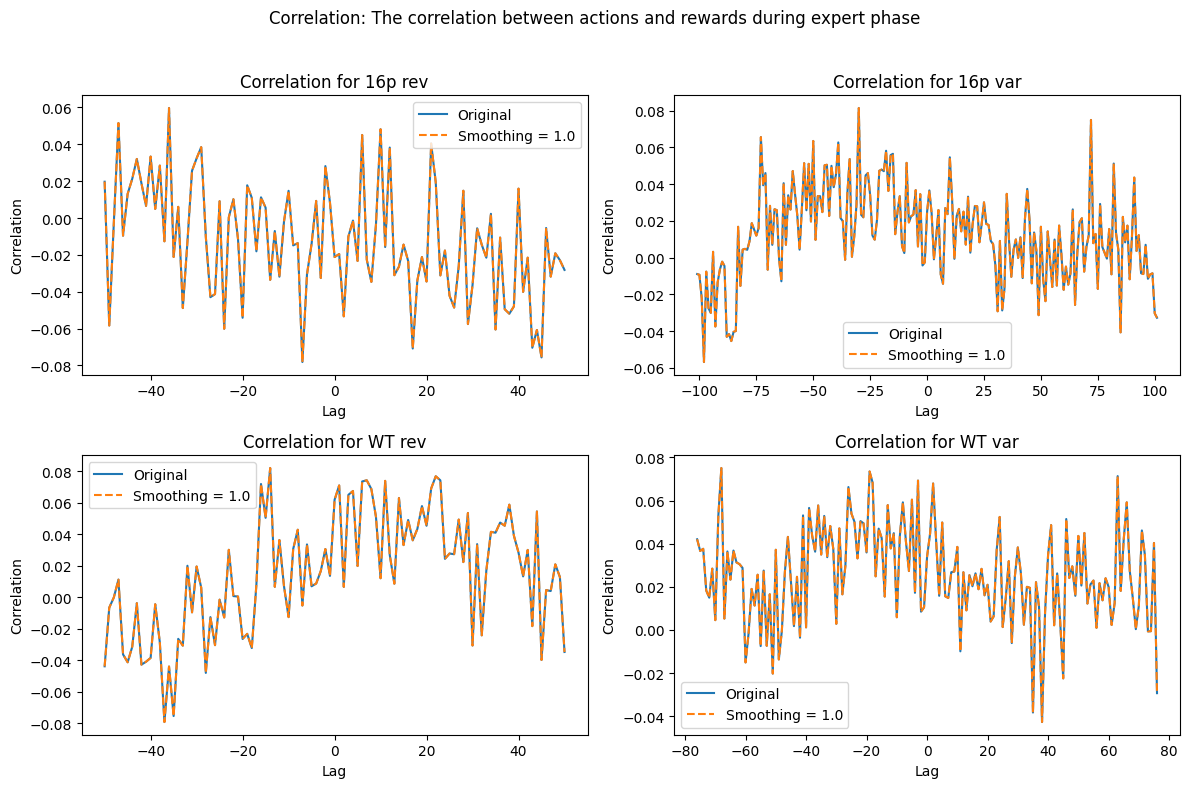

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import correlate

# Load the Excel file
df = pd.read_excel('/Users/saadabdisalam/Documents/MouseData_and_Analysis2024-2025/Mouse_DATA.xlsx')
mouse_per_mouse_type = int(input('How many mouse/mouse_type would you like choose numbers ranging from 1 to 5?'))
# Ensure column names are correct
links_16p_rev = df['link_16p_rev'].iloc[:mouse_per_mouse_type].dropna().tolist()
links_16p_var = df['link_16p_var'].iloc[:mouse_per_mouse_type].dropna().tolist()
links_WT_rev = df['link_WT_rev'].iloc[:mouse_per_mouse_type].dropna().tolist()
links_WT_var = df['link_WT_var'].iloc[:mouse_per_mouse_type].dropna().tolist()

def find_expert_segments(expert_series, rew_prob, choice):
    expert_segments = []
    in_segment = False
    segment_start = None
    
    for i in range(len(expert_series)):
        if (expert_series[i] and rew_prob[i]==0.9) and not in_segment:
            in_segment = True
            segment_start = i
        elif not (expert_series[i] and rew_prob[i]==0.9) and in_segment:
            in_segment = False
            expert_segments.append([segment_start, i - 1])
            segment_start = None

    if in_segment:
        expert_segments.append([segment_start, len(expert_series) - 1])
    
    if choice == 1 and expert_segments:
        expert_segments = [expert_segments[0]]
    
    return expert_segments

def max_lag_per_mouseType(links, choice):
    dic = {}
    for link in links:
        df = pd.read_csv('/Users/saadabdisalam/Documents/MouseData_and_Analysis2024-2025/' + link)
        expert_series = df['expert'].reset_index(drop=True)
        rew_prob = df['rew_prob'].reset_index(drop=True)
        expert_segments = find_expert_segments(expert_series, rew_prob, choice)
        dic[link] = expert_segments
    return dic

choice = int(input("Enter 1 to extract only one expert phase, or 2 to allow multiple expert phases: ").strip())

Expert_16p_rev = max_lag_per_mouseType(links_16p_rev, choice)
Expert_16p_var = max_lag_per_mouseType(links_16p_var, choice)
Expert_WT_rev = max_lag_per_mouseType(links_WT_rev, choice)
Expert_WT_var = max_lag_per_mouseType(links_WT_var, choice)

def SAR_Generator(mouse_type_links, choice):
    Expert_mouse_type = max_lag_per_mouseType(mouse_type_links, choice)
    sar_dict = {link: {'states': [], 'actions': [], 'rewards': []} for link in mouse_type_links}

    for link in mouse_type_links:
        start_link, end_link = Expert_mouse_type[link][0]
        df = pd.read_csv('/Users/saadabdisalam/Documents/MouseData_and_Analysis2024-2025/' + link)
        
        S = df['tone_freq'].iloc[start_link:end_link+1].replace({6000: '6kHz', 10000: '10kHz'}).reset_index(drop=True)
        A = df['response'].iloc[start_link:end_link+1].reset_index(drop=True)
        R = df['rew_t'].iloc[start_link:end_link+1].reset_index(drop=True)
        
        sar_dict[link]['states'].extend(S)
        sar_dict[link]['actions'].extend(A)
        sar_dict[link]['rewards'].extend(R)

    return sar_dict

def cross_correlation_manual(x, y, mx_lag):
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    c_lag = []

    for lag in range(-mx_lag, mx_lag + 1):
        if lag < 0:
            segment_x = x[-lag:]
            segment_y = y[:len(x) + lag]
        else:
            segment_x = x[:len(x) - lag]
            segment_y = y[lag:]
        
        std_x = np.std(segment_x)
        std_y = np.std(segment_y)
        
        if std_x != 0 and std_y != 0:
            c = np.sum((segment_x - mean_x) * (segment_y - mean_y))
            c_lag.append(c / (std_x * std_y * len(segment_x)))
        else:
            c_lag.append(0)
    
    return c_lag

def AR_mapping(mouse_type_links, choice):
    dic_mouse_type = SAR_Generator(mouse_type_links, choice)
    DIC_AR = {link: [] for link in mouse_type_links}
    for link in mouse_type_links:
        actions = dic_mouse_type[link]['actions']
        rewards = dic_mouse_type[link]['rewards']
        Y = []
        for i in range(len(actions)):
            if actions[i] == 'L' and rewards[i] == 1:
                Y_i = 2
            elif actions[i] == 'L' and rewards[i] == 0:
                Y_i = 1
            elif actions[i] == 'R' and rewards[i] == 0:
                Y_i = -1
            elif actions[i] == 'R' and rewards[i] == 1:
                Y_i = -2
            elif actions[i] == 'N':
                Y_i = 0
            Y.append(Y_i)
        DIC_AR[link].extend(Y)
    return DIC_AR

def S_mapping(mouse_type_links, choice):
    dic_mouse_type = SAR_Generator(mouse_type_links, choice)
    DIC_S = {link: [] for link in mouse_type_links}
    for link in mouse_type_links:
        states = dic_mouse_type[link]['states']
        X = []
        for i in range(len(states)):
            if states[i] == '6kHz':
                X_i = 1
            elif states[i] == '10kHz':
                X_i = 0
            X.append(X_i)
        DIC_S[link].extend(X)
    return DIC_S

def SA_mapping(mouse_type_links, choice):
    dic_mouse_type = SAR_Generator(mouse_type_links, choice)
    DIC_SA = {link: [] for link in mouse_type_links}
    for link in mouse_type_links:
        states = dic_mouse_type[link]['states']
        actions = dic_mouse_type[link]['actions']
        X = []
        for i in range(len(states)):
            if (states[i] == '6kHz' and actions[i] == 'L') or (states[i] == '10kHz' and actions[i] == 'R'):
                X_i = 1
            elif (states[i] == '6kHz' and actions[i] == 'R') or (states[i] == '10kHz' and actions[i] == 'L'):
                X_i = -1
            else:
                X_i = 0
            X.append(X_i)
        DIC_SA[link].extend(X)
    return DIC_SA

def A_mapping(mouse_type_links, choice):
    dic_mouse_type = SAR_Generator(mouse_type_links, choice)
    DIC_A = {link: [] for link in mouse_type_links}
    for link in mouse_type_links:
        actions = dic_mouse_type[link]['actions']
        Y = []
        for i in range(len(actions)):
            if actions[i] == 'L':
                Y_i = 1
            elif actions[i] == 'R':
                Y_i = -1
            else:
                Y_i = 0
            Y.append(Y_i)
        DIC_A[link].extend(Y)
    return DIC_A

def R_mapping(mouse_type_links, choice):
    dic_mouse_type = SAR_Generator(mouse_type_links, choice)
    DIC_R = {link: [] for link in mouse_type_links}
    for link in mouse_type_links:
        rewards = dic_mouse_type[link]['rewards']
        X = []
        for i in range(len(rewards)):
            if rewards[i] == 1:
                X_i = 1
            else:
                X_i = 0
            X.append(X_i)
        DIC_R[link].extend(X)
    return DIC_R

def min_expert_length(mouse_type_links, choice):
    dic_mouse_type = SAR_Generator(mouse_type_links, choice)
    lengths = []
    for link in mouse_type_links:
        rewards = dic_mouse_type[link]['rewards']
        lengths.append(len(rewards))
    max_lag = int(0.2 * min(lengths))
    return max_lag

def avg_correlate(mouse_type_links, choice):
    #correlator : A(t+tau)R(t)
    max_lag = min_expert_length(mouse_type_links, choice)
    total_corr = np.array(np.zeros(2*max_lag+1))
    num_links = len(mouse_type_links)
    #lag_var = input('What do you want your lag variable to be (R_seq/SA_seq)? '
    corrs=[]
    for link in mouse_type_links:
        DIC_R = R_mapping(mouse_type_links, choice)
        DIC_A = A_mapping(mouse_type_links, choice)
        R_seq = DIC_R[link]
        A_seq= DIC_A[link]
        
        cross_corr = cross_correlation_manual(R_seq, A_seq,max_lag)
        total_corr += cross_corr
    lags = list(range(-max_lag, max_lag + 1))
    return total_corr / num_links, lags

def exponential_smoothing(series, alpha):
    return series.ewm(alpha=alpha).mean()

# Plotting
y_16p_rev, x_16p_rev = avg_correlate(links_16p_rev, choice)
y_16p_var, x_16p_var = avg_correlate(links_16p_var, choice)
y_WT_rev, x_WT_rev = avg_correlate(links_WT_rev, choice)
y_WT_var, x_WT_var = avg_correlate(links_WT_var, choice)

# Apply exponential smoothing
alpha = float(input('What smoothing value would you like?'))  # Smoothing factor, can be adjusted
y_16p_rev_smoothed = exponential_smoothing(pd.Series(y_16p_rev), alpha).values
y_16p_var_smoothed = exponential_smoothing(pd.Series(y_16p_var), alpha).values
y_WT_rev_smoothed = exponential_smoothing(pd.Series(y_WT_rev), alpha).values
y_WT_var_smoothed = exponential_smoothing(pd.Series(y_WT_var), alpha).values


# Plot the results
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(x_16p_rev, y_16p_rev, label='Original')
plt.plot(x_16p_rev, y_16p_rev_smoothed, label=f'Smoothing = {alpha}', linestyle='--')
plt.title('Correlation for 16p rev')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(x_16p_var, y_16p_var, label='Original')
plt.plot(x_16p_var, y_16p_var_smoothed, label=f'Smoothing = {alpha}', linestyle='--')
plt.title('Correlation for 16p var')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(x_WT_rev, y_WT_rev, label='Original')
plt.plot(x_WT_rev, y_WT_rev_smoothed, label=f'Smoothing = {alpha}', linestyle='--')
plt.title('Correlation for WT rev')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(x_WT_var, y_WT_var, label='Original')
plt.plot(x_WT_var, y_WT_var_smoothed, label=f'Smoothing = {alpha}', linestyle='--')
plt.title('Correlation for WT var')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.legend()

# Add a single title for all plots
plt.suptitle('Correlation: The correlation between actions and rewards during expert phase')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

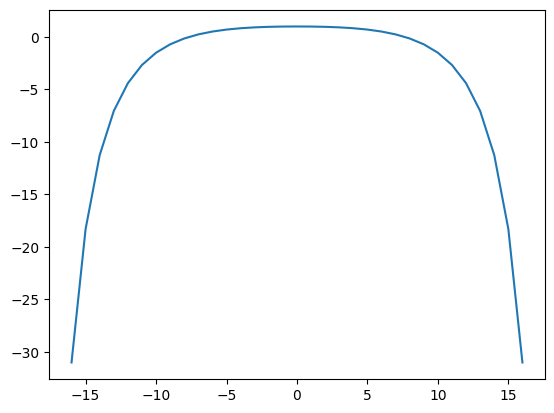

In [1]:
import numpy as np
import matplotlib.pyplot as plt


def cross_correlation_manual(x, y, mx_lag):
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    c_lag = []

    for lag in range(-mx_lag, mx_lag + 1):
        if lag < 0:
            segment_x = x[-lag:]
            segment_y = y[:len(x) + lag]
        else:
            segment_x = x[:len(x) - lag]
            segment_y = y[lag:]
        
        std_x = np.std(segment_x)
        std_y = np.std(segment_y)
        
        if std_x != 0 and std_y != 0:
            c = np.sum((segment_x - mean_x) * (segment_y - mean_y))
            c_lag.append(c / (std_x * std_y * len(segment_x)))
        else:
            c_lag.append(0)
    
    return c_lag


x = [2*i for i in range(1, 22)]
y = [2*(i) for i in range(1,22)]

max = int(0.8*len(x))

lags = list(range(-max, max+1))

plt.plot(lags, cross_correlation_manual(x,y,max))
plt.show()


{'mouse_data_6149_16p11.2_rev_prob.csv': [[1403, 1656]], 'mouse_data_6212_16p11.2_rev_prob.csv': [[1374, 1627]], 'mouse_data_6213_16p11.2_rev_prob.csv': [[992, 1245]], 'mouse_data_6244_16p11.2_rev_prob.csv': [[1182, 1437]], 'mouse_data_6344_16p11.2_rev_prob.csv': [[1087, 1340]]}
{'mouse_data_6557_16p11.2_var_prob.csv': [[1569, 2073]], 'mouse_data_6561_16p11.2_var_prob.csv': [[1729, 2233]], 'mouse_data_6562_16p11.2_var_prob.csv': [[1854, 2358]], 'mouse_data_6563_16p11.2_var_prob.csv': [[1272, 1776]], 'mouse_data_6569_16p11.2_var_prob.csv': [[1878, 2382]]}
{'mouse_data_6150_WT_rev_prob.csv': [[2367, 2620]], 'mouse_data_6210_WT_rev_prob.csv': [[4215, 4468]], 'mouse_data_6211_WT_rev_prob.csv': [[1177, 1430]], 'mouse_data_6240_WT_rev_prob.csv': [[1098, 1352]], 'mouse_data_6242_WT_rev_prob.csv': [[804, 1058]]}
{'mouse_data_6558_WT_var_prob.csv': [[1937, 2441]], 'mouse_data_6560_WT_var_prob.csv': [[1880, 2384]], 'mouse_data_6564_WT_var_prob.csv': [[1298, 1802]], 'mouse_data_6565_WT_var_prob.c

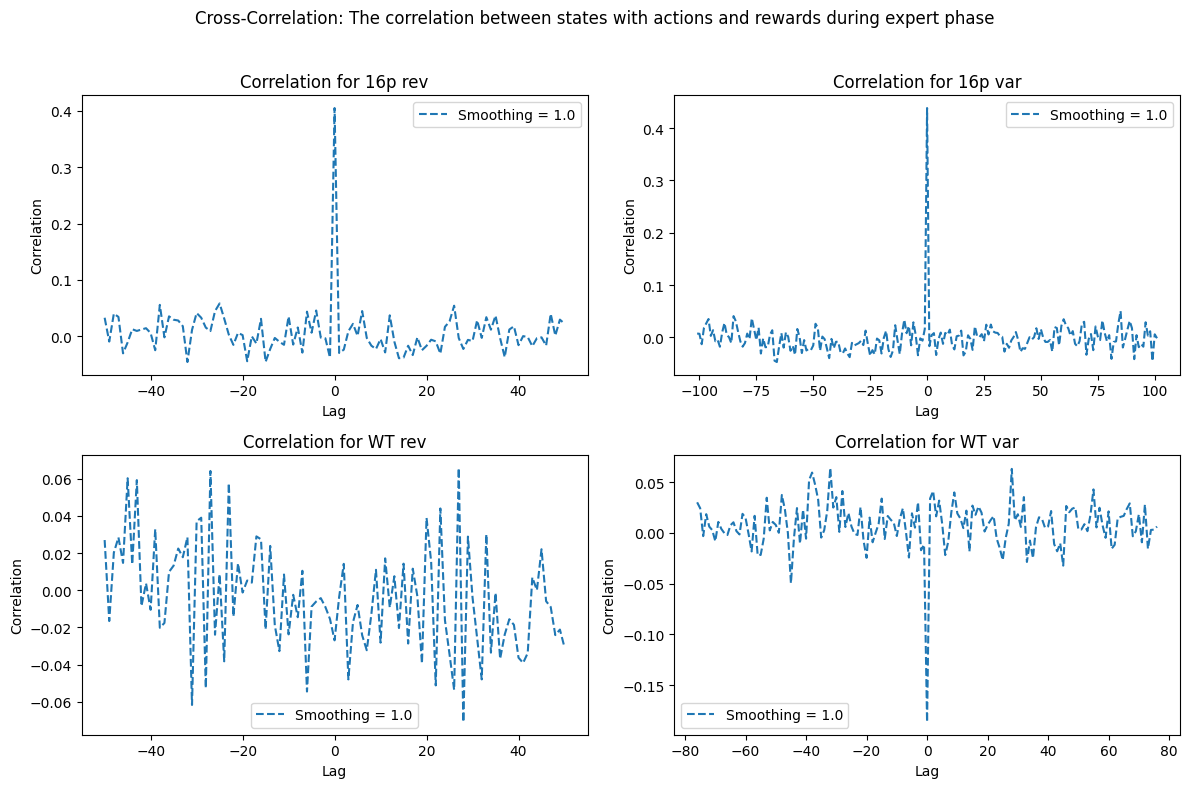

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import correlate



# Load the Excel file
df = pd.read_excel('/Users/saadabdisalam/Documents/MouseData_and_Analysis2024-2025/Mouse_DATA.xlsx')
mouse_per_mouse_type = int(input('How many mouse/mouse_type would you like choose numbers ranging from 1 to 5?'))
# Ensure column names are correct
links_16p_rev = df['link_16p_rev'].iloc[:mouse_per_mouse_type].tolist()
links_16p_var = df['link_16p_var'].iloc[:mouse_per_mouse_type].tolist()
links_WT_rev = df['link_WT_rev'].iloc[:mouse_per_mouse_type].tolist()
links_WT_var = df['link_WT_var'].iloc[:mouse_per_mouse_type].tolist()

def find_expert_segments(expert_series, rew_prob, choice):
    expert_segments = []
    in_segment = False
    segment_start = None
    
    for i in range(len(expert_series)):
        if (expert_series[i] and rew_prob[i]==0.9) and not in_segment:
            in_segment = True
            segment_start = i
        elif not (expert_series[i] and rew_prob[i]==0.9) and in_segment:
            in_segment = False
            expert_segments.append([segment_start, i - 1])
            segment_start = None

    if in_segment:
        expert_segments.append([segment_start, len(expert_series) - 1])
    
    if choice == 1 and expert_segments:
        expert_segments = [expert_segments[0]]
    
    return expert_segments

def max_lag_per_mouseType(links, choice):
    dic = {}
    for link in links:
        df = pd.read_csv('/Users/saadabdisalam/Documents/MouseData_and_Analysis2024-2025/' + link)
        expert_series = df['expert'].reset_index(drop=True)
        rew_prob = df['rew_prob'].reset_index(drop=True)
        expert_segments = find_expert_segments(expert_series, rew_prob, choice)
        dic[link] = expert_segments
    return dic


choice = int(input("Enter 1 to extract only one expert phase, or 2 to allow multiple expert phases: ").strip())

Expert_16p_rev = max_lag_per_mouseType(links_16p_rev, choice)
Expert_16p_var = max_lag_per_mouseType(links_16p_var, choice)
Expert_WT_rev = max_lag_per_mouseType(links_WT_rev, choice)
Expert_WT_var = max_lag_per_mouseType(links_WT_var, choice)
print(Expert_16p_rev)
print(Expert_16p_var)
print(Expert_WT_rev)
print(Expert_WT_var)

def SAR_Generator(mouse_type_links, choice):
    Expert_mouse_type = max_lag_per_mouseType(mouse_type_links, choice)
    sar_dict = {link: {'states': [], 'actions': [], 'rewards': []} for link in mouse_type_links}

    for link in mouse_type_links:
        start_link, end_link = Expert_mouse_type[link][0]
        df = pd.read_csv('/Users/saadabdisalam/Documents/MouseData_and_Analysis2024-2025/' + link)
        
        S = df['tone_freq'].iloc[start_link:end_link+1].replace({6000: '6kHz', 10000: '10kHz'}).reset_index(drop=True)
        A = df['response'].iloc[start_link:end_link+1].reset_index(drop=True)
        R = df['rew_t'].iloc[start_link:end_link+1].reset_index(drop=True)
        
        sar_dict[link]['states'].extend(S)
        sar_dict[link]['actions'].extend(A)
        sar_dict[link]['rewards'].extend(R)

    return sar_dict

def cross_correlation_manual(x, y, max_lag):
    # Detrend the data
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    x_detrended = x - mean_x
    y_detrended = y - mean_y
    
    c_lag = []

    for lag in range(-max_lag, max_lag + 1):
        if lag < 0:
            segment_x = x_detrended[-lag:]
            segment_y = y_detrended[:len(segment_x)]
        else:
            segment_x = x_detrended[:len(x) - lag]
            segment_y = y_detrended[lag:]
        
        # Calculate covariance without normalization by standard deviation
        if len(segment_x) != 0:
            c = np.sum(segment_x * segment_y)
            c_lag.append(c/len(segment_x)*np.std(x)*np.std(y))
        else:
            c_lag.append(0)

    return c_lag

def AR_mapping(mouse_type_links, choice):
    dic_mouse_type = SAR_Generator(mouse_type_links, choice)
    DIC_AR = {link: [] for link in mouse_type_links}
    for link in mouse_type_links:
        actions = dic_mouse_type[link]['actions']
        rewards = dic_mouse_type[link]['rewards']
        Y = []
        for i in range(len(actions)):
            if actions[i] == 'L' and rewards[i] == 1:
                Y_i = 2
            elif actions[i] == 'L' and rewards[i] == 0:
                Y_i = 1
            elif actions[i] == 'R' and rewards[i] == 0:
                Y_i = -1
            elif actions[i] == 'R' and rewards[i] == 1:
                Y_i = -2
            elif actions[i] == 'N':
                Y_i = 0
            Y.append(Y_i)
        DIC_AR[link].extend(Y)
    return DIC_AR

def S_mapping(mouse_type_links, choice):
    dic_mouse_type = SAR_Generator(mouse_type_links, choice)
    DIC_S = {link: [] for link in mouse_type_links}
    for link in mouse_type_links:
        states = dic_mouse_type[link]['states']
        X = []
        for i in range(len(states)):
            if states[i] == '6kHz':
                X_i = 1
            elif states[i] == '10kHz':
                X_i = -1
            X.append(X_i)
        DIC_S[link].extend(X)
    return DIC_S

def SA_mapping(mouse_type_links, choice):   
    dic_mouse_type = SAR_Generator(mouse_type_links, choice)
    DIC_SA = {link: [] for link in mouse_type_links}
    for link in mouse_type_links:
        states = dic_mouse_type[link]['states']
        actions = dic_mouse_type[link]['actions']
        X = []
        for i in range(len(states)):
            if (states[i] == '6kHz' and actions[i] == 'L') or (states[i] == '10kHz' and actions[i] == 'R'):
                X_i = 1
            elif (states[i] == '6kHz' and actions[i] == 'R') or (states[i] == '10kHz' and actions[i] == 'L'):
                X_i = -1
            else:
                X_i = 0
            X.append(X_i)
        DIC_SA[link].extend(X)
    return DIC_SA

def A_mapping(mouse_type_links, choice):
    dic_mouse_type = SAR_Generator(mouse_type_links, choice)
    DIC_A = {link: [] for link in mouse_type_links}
    DIC_S = S_mapping(mouse_type_links, choice) 
    for link in mouse_type_links:
        actions = dic_mouse_type[link]['actions']
        Y = []
        for i in range(len(actions)):
            if actions[i] == 'L':
                Y_i = 1
            elif actions[i] == 'R':
                Y_i = -1
            else:
                Y_i = DIC_S[link][i]
            Y.append(Y_i)
        DIC_A[link].extend(Y)
    return DIC_A

def R_mapping(mouse_type_links, choice):
    dic_mouse_type = SAR_Generator(mouse_type_links, choice)
    DIC_R = {link: [] for link in mouse_type_links}
    for link in mouse_type_links:
        rewards = dic_mouse_type[link]['rewards']
        X = []
        for i in range(len(rewards)):
            if rewards[i] == 1:
                X_i = 1
            else:
                X_i = -1
            X.append(X_i)
        DIC_R[link].extend(X)
    return DIC_R

def min_expert_length(mouse_type_links, choice):
    dic_mouse_type = SAR_Generator(mouse_type_links, choice)
    lengths = []
    for link in mouse_type_links:
        rewards = dic_mouse_type[link]['rewards']
        lengths.append(len(rewards))
    max_lag = int(0.2 * min(lengths))
    return max_lag

def avg_correlate(mouse_type_links, choice):
    #correlator : A(t+tau)R(t)
    max_lag = min_expert_length(mouse_type_links, choice)
    total_corr = np.array(np.zeros(2*max_lag+1))
    num_links = len(mouse_type_links)
    print(num_links)
    #lag_var = input('What do you want your lag variable to be (R_seq/SA_seq)? '
    corrs=[]
    DIC_R = S_mapping(mouse_type_links, choice)
    DIC_SA = A_mapping(mouse_type_links, choice)
    for link in mouse_type_links: 
        R_seq = DIC_R[link]
        SA_seq= DIC_SA[link]
        
        cross_corr = cross_correlation_manual(R_seq, SA_seq,max_lag)
        total_corr += cross_corr
      #  print(cross_corr[:3])
    #print(total_corr[:3])
    lags = list(range(-max_lag, max_lag + 1))
    return total_corr / num_links, lags

def exponential_smoothing(series, alpha):
    return series.ewm(alpha=alpha).mean()

# Plotting
y_16p_rev, x_16p_rev = avg_correlate(links_16p_rev, choice)
y_16p_var, x_16p_var = avg_correlate(links_16p_var, choice)
y_WT_rev, x_WT_rev = avg_correlate(links_WT_rev, choice)
y_WT_var, x_WT_var = avg_correlate(links_WT_var, choice)

# Apply exponential smoothing
alpha = float(input('What smoothing value would you like?'))  # Smoothing factor, can be adjusted
y_16p_rev_smoothed = exponential_smoothing(pd.Series(y_16p_rev), alpha).values
y_16p_var_smoothed = exponential_smoothing(pd.Series(y_16p_var), alpha).values
y_WT_rev_smoothed = exponential_smoothing(pd.Series(y_WT_rev), alpha).values
y_WT_var_smoothed = exponential_smoothing(pd.Series(y_WT_var), alpha).values

print("Large Positive correlation: [correct(s,a), rewarded], [incorrect(s,a), not rewarded]")
print("Large Negative correlation: [incorrect(s,a), rewarded], [correct(s,a), not rewarded]")
# Plot the results
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
#plt.plot(x_16p_rev, y_16p_rev, label='Original')
plt.plot(x_16p_rev, y_16p_rev_smoothed, label=f'Smoothing = {alpha}', linestyle='--')
plt.title('Correlation for 16p rev')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.legend()

plt.subplot(2, 2, 2)
#plt.plot(x_16p_var, y_16p_var, label='Original')
plt.plot(x_16p_var, y_16p_var_smoothed, label=f'Smoothing = {alpha}', linestyle='--')
plt.title('Correlation for 16p var')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.legend()

plt.subplot(2, 2, 3)
#plt.plot(x_WT_rev, y_WT_rev, label='Original')
plt.plot(x_WT_rev, y_WT_rev_smoothed, label=f'Smoothing = {alpha}', linestyle='--')
plt.title('Correlation for WT rev')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.legend()

plt.subplot(2, 2, 4)
#plt.plot(x_WT_var, y_WT_var, label='Original')
plt.plot(x_WT_var, y_WT_var_smoothed, label=f'Smoothing = {alpha}', linestyle='--')
plt.title('Correlation for WT var')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.legend()

# Add a single title for all plots
plt.suptitle('Cross-Correlation: The correlation between states with actions and rewards during expert phase')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()




In [4]:
import numpy as np
u = [1, 2, 3]
v = [3, 6, 7]

print((u - np.mean(u))*(v-np.mean(v)))

[2.33333333 0.         1.66666667]


Smoothing = 1.0 B = 9.0 T = 100000 A = 0.1
Length of expert phase = 200


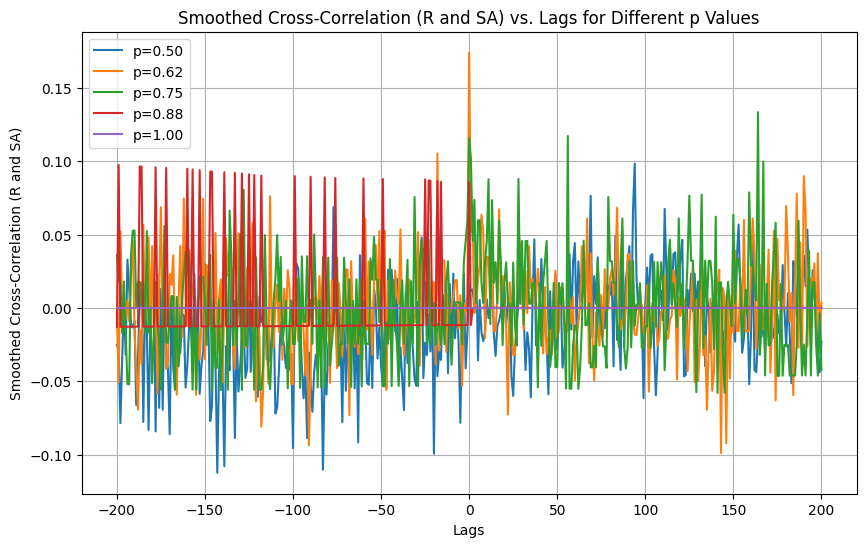

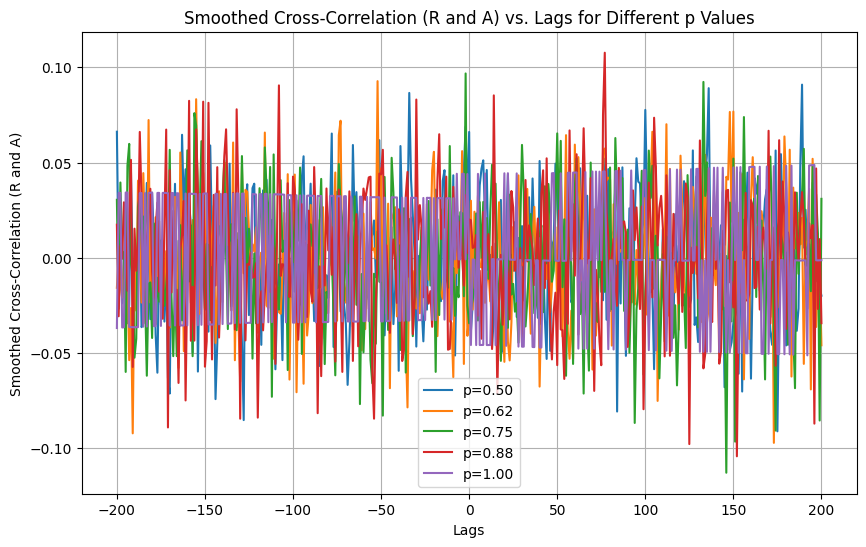

In [1]:
import numpy as np
import pandas as pd
from OOP_SyntheticData import Simulation
import matplotlib.pyplot as plt

def SAR_Generator(states, actions, rewards, expert_series):
    if not expert_series or len(expert_series[0]) != 2:
        raise ValueError("expert_series is empty or improperly formatted")
    start, finish = expert_series[0]
    
    new_states  = states[start:finish + 1]
    new_actions = actions[start:finish + 1]
    new_rewards = rewards[start:finish + 1]
    return new_states, new_actions, new_rewards


def cross_correlation_manual(x, y, mx_lag):
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    c_lag = []

    for lag in range(-mx_lag, mx_lag + 1):
        if lag < 0:
            segment_x = x[-lag:]
            segment_y = y[:len(x) + lag]
        else:
            segment_x = x[:len(x) - lag]
            segment_y = y[lag:]
        
        std_x = np.std(segment_x)
        std_y = np.std(segment_y)
        
        if std_x != 0 and std_y != 0:
            c = np.sum((segment_x - mean_x) * (segment_y - mean_y))
            c_lag.append(c / (std_x * std_y * len(segment_x)))
        else:
            c_lag.append(0)
    
    return c_lag




def AR_mapping(states, actions, rewards, expert_series):
    States, Actions, Rewards = SAR_Generator(states, actions, rewards, expert_series)
    Y=[]
    for i in range(len(Actions)):
        if Actions[i] == 'L' and Rewards[i] == 1:
            Y_i = 2
        elif Actions[i] == 'L' and Rewards[i] == 0:
            Y_i = 1
        elif Actions[i] == 'R' and Rewards[i] == 0:
            Y_i = -1
        elif Actions[i] == 'R' and Rewards[i] == 1:
            Y_i = -2
        elif Actions[i] == 'N':
            Y_i = 0
        Y.append(Y_i)
    return Y

def S_mapping(states, actions, rewards, expert_series):
    States, Actions, Rewards = SAR_Generator(states, actions, rewards, expert_series)
    X = []
    for i in range(len(States)):
        if States[i] == '6kHz':
            X_i = 1
        elif States[i] == '10kHz':
            X_i = -1
        X.append(X_i)
    return X

def SA_mapping(states, actions, rewards, expert_series):
    States, Actions, Rewards = SAR_Generator(states, actions, rewards, expert_series)
    X = []
    for i in range(len(States)):
        if (States[i] == '6kHz' and Actions[i] == 'L') or (States[i] == '10kHz' and Actions[i] == 'R'):
            X_i = 1
        elif (States[i] == '6kHz' and Actions[i] == 'R') or (States[i] == '10kHz' and Actions[i] == 'L'):
            X_i = -1
        else:
            X_i = 0
        X.append(X_i)
    return X

def A_mapping(states, actions, rewards, expert_series):
    States, Actions, Rewards = SAR_Generator(states, actions, rewards, expert_series)
    Y = []
    for i in range(len(Actions)):
        if Actions[i] == 'L':
            Y_i = 1
        elif Actions[i] == 'R':
            Y_i = -1
        else:
            Y_i = 0
        Y.append(Y_i)
    return Y

def R_mapping(states, actions, rewards, expert_series):
    States, Actions, Rewards = SAR_Generator(states, actions, rewards, expert_series)
    X = []
    for i in range(len(Rewards)):
        if Rewards[i] == 1:
            X_i = 1
        else:
            X_i = 0
        X.append(X_i)
    return X

def avg_correlate_R_SA(states, actions, rewards, expert_series, expert_length):
    max_lag = int(0.2*(expert_length))
    R_seq = R_mapping(states, actions, rewards, expert_series)
    SA_seq = SA_mapping(states, actions, rewards, expert_series)
    cross_corr = cross_correlation_manual(R_seq, SA_seq, max_lag)
    lags = list(range(-max_lag, max_lag + 1))
    return cross_corr, lags

def avg_correlate_R_A(states, actions, rewards, expert_series, expert_length):
    max_lag = int(0.2*(expert_length))
    R_seq = R_mapping(states, actions, rewards, expert_series)
    A_seq = A_mapping(states, actions, rewards, expert_series)
    cross_corr = cross_correlation_manual(R_seq, A_seq, max_lag)
    lags = list(range(-max_lag, max_lag + 1))
    return cross_corr, lags

def exponential_smoothing(series, alpha):
  
    return series.ewm(alpha=alpha).mean()


# Main code
# Main code
def main(T, A, B, p, alpha, expert_length):
    sim = Simulation(T, p, expert_length)
    states, actions, rewards, _, _, expert_series = sim.Generate_SAR(A, B)
    y_mouse_rev_R_SA, x_mouse_rev_R_SA = avg_correlate_R_SA(states, actions, rewards, expert_series, expert_length)
    y_mouse_rev_R_A, x_mouse_rev_R_A = avg_correlate_R_A(states, actions, rewards, expert_series, expert_length)
    y_mouse_rev_smoothed_R_SA = exponential_smoothing(pd.Series(y_mouse_rev_R_SA), alpha).values
    y_mouse_rev_smoothed_R_A = exponential_smoothing(pd.Series(y_mouse_rev_R_A), alpha).values
    return {'R_SA': [x_mouse_rev_R_SA, y_mouse_rev_smoothed_R_SA], 'R_A': [x_mouse_rev_R_A, y_mouse_rev_smoothed_R_A]}

ps = np.linspace(0.5, 1, 5)
alpha = float(input('What smoothing value would you like? (between 0 and 1): ').strip())
T = int(input('What number of trials would you like? '))
A = float(input('What learning rate would you like? '))
B = float(input('What beta would you like? '))
N = int(input("How large a lag do you want"))

if __name__ == "__main__":
    print(f"Smoothing = {alpha}", f"B = {B}", f"T = {T}", f"A = {A}")
    print(f'Length of expert phase = {N}')

    plt.figure(figsize=(10, 6))
    
    for p in ps:
        x_mouse_rev, y_mouse_rev_smoothed_R_SA = main(T, A, B, p, alpha, expert_length=N/0.2)['R_SA']
        plt.plot(x_mouse_rev, y_mouse_rev_smoothed_R_SA, label=f'p={p:.2f}')
   
    plt.xlabel('Lags')
    plt.ylabel('Smoothed Cross-Correlation (R and SA)')
    plt.title('Smoothed Cross-Correlation (R and SA) vs. Lags for Different p Values')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    for p in ps:
        x_mouse_rev, y_mouse_rev_smoothed_R_A = main(T, A, B, p, alpha, expert_length=N/0.2)['R_A']
        plt.plot(x_mouse_rev, y_mouse_rev_smoothed_R_A, label=f'p={p:.2f}')

    plt.xlabel('Lags')
    plt.ylabel('Smoothed Cross-Correlation (R and A)')
    plt.title('Smoothed Cross-Correlation (R and A) vs. Lags for Different p Values')
    plt.legend()
    plt.grid(True)
    plt.show()

    # To avoid std = 0, try betas that are small and large number of trials 
    # usually p = 1, has std = 0

Expert series start and finish: 359 1608
Expert series start and finish: 359 1608
Expert series start and finish: 359 1608
Expert series start and finish: 359 1608
Expert series start and finish: 3397 4646
Expert series start and finish: 3397 4646
Expert series start and finish: 3397 4646
Expert series start and finish: 3397 4646
Expert series start and finish: 2407 3656
Expert series start and finish: 2407 3656
Expert series start and finish: 2407 3656
Expert series start and finish: 2407 3656
Expert series start and finish: 1040 2289
Expert series start and finish: 1040 2289
Expert series start and finish: 1040 2289
Expert series start and finish: 1040 2289
Expert series start and finish: 1980 3229
Expert series start and finish: 1980 3229
Expert series start and finish: 1980 3229
Expert series start and finish: 1980 3229
Expert series start and finish: 937 2186
Expert series start and finish: 937 2186
Expert series start and finish: 937 2186
Expert series start and finish: 937 2186


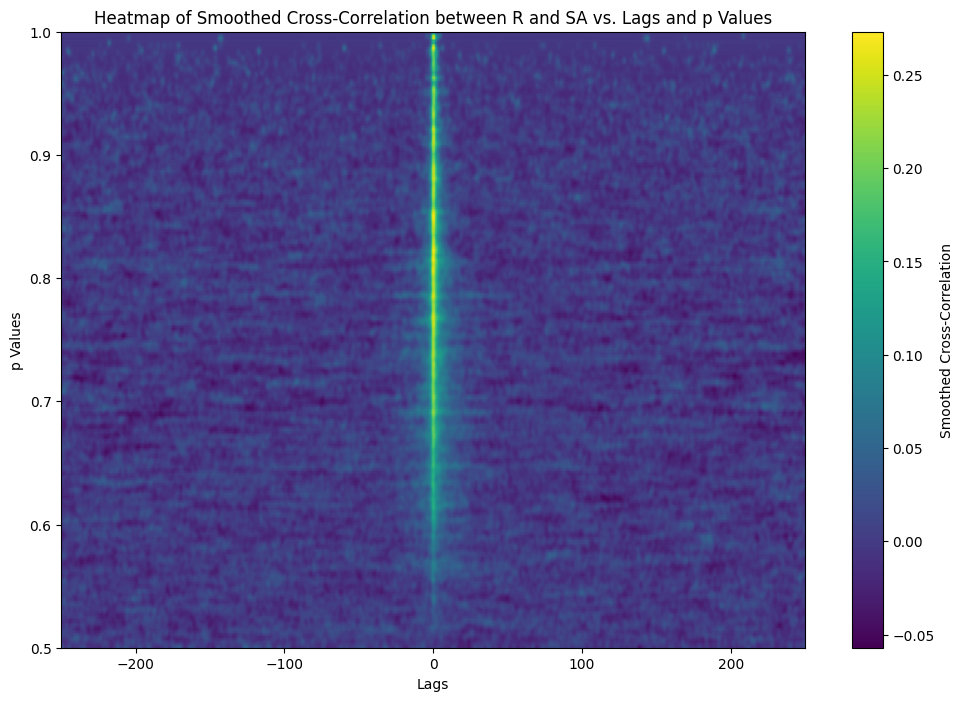

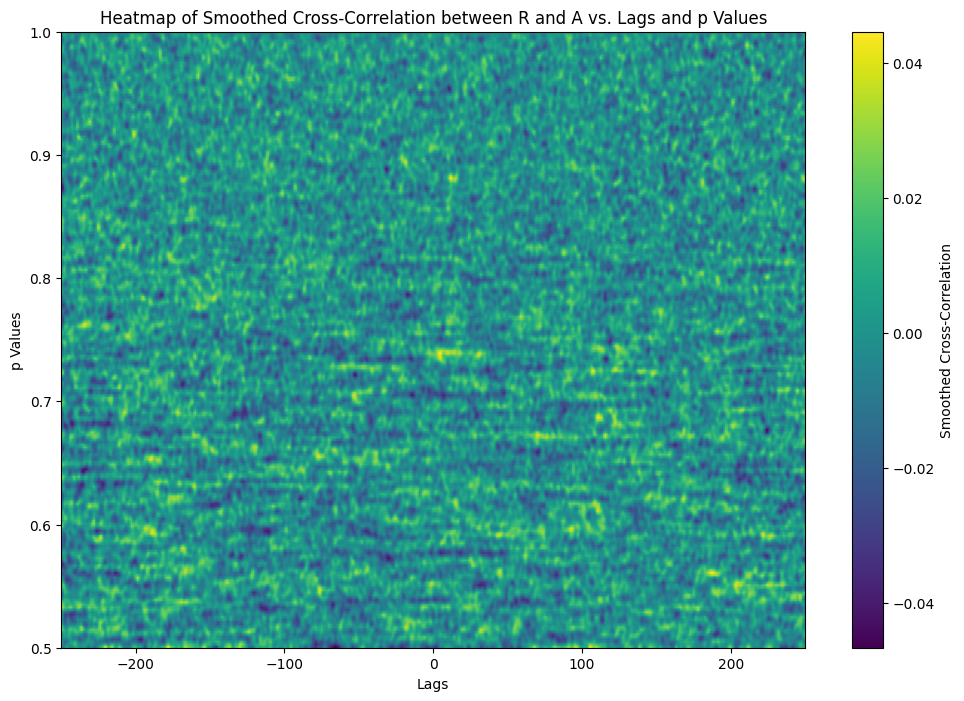

In [1]:
import numpy as np
import pandas as pd
from OOP_SyntheticData import Simulation
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

def SAR_Generator(states, actions, rewards, expert_series):
    if not expert_series or len(expert_series[0]) != 2:
        raise ValueError("expert_series is empty or improperly formatted")
    start, finish = expert_series[0]
    print("Expert series start and finish:", start, finish)
    new_states  = states[start:finish + 1]
    new_actions = actions[start:finish + 1]
    new_rewards = rewards[start:finish + 1]
    return new_states, new_actions, new_rewards


def cross_correlation_manual(x, y, lag_var, mx_lag):
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    c_lag = []

    for lag in range(-mx_lag, mx_lag + 1):
        if lag_var == 'x':
            if lag >= 0:
                segment_x = x[lag:]
                segment_y = y[:len(x) - lag]
            else:
                segment_x = x[:len(x) + lag]
                segment_y = y[-lag:]
        else:
            if lag >= 0:
                segment_x = x[:len(x) - lag]
                segment_y = y[lag:]
            else:
                segment_x = x[-lag:]
                segment_y = y[:len(y) + lag]

        # Ensure segment_x and segment_y are the same length for this lag
        min_len = len(segment_x)  # This is len(x) - abs(lag)
        segment_y = segment_y[:min_len]
        segment_x = segment_x[:min_len]

        std_x = np.std(segment_x)
        std_y = np.std(segment_y)
        c = np.sum((segment_x - mean_x) * (segment_y - mean_y))
        normalization_factor = float(std_x) * float(std_y) * min_len
        
        if normalization_factor != 0:
            c_lag.append(c / normalization_factor)
        else:
            c_lag.append(0)
    
    return c_lag

def AR_mapping(states, actions, rewards, expert_series):
    States, Actions, Rewards = SAR_Generator(states, actions, rewards, expert_series)
    Y = []
    for i in range(len(Actions)):
        if Actions[i] == 'L' and Rewards[i] == 1:
            Y_i = 2
        elif Actions[i] == 'L' and Rewards[i] == 0:
            Y_i = 1
        elif Actions[i] == 'R' and Rewards[i] == 0:
            Y_i = -1
        elif Actions[i] == 'R' and Rewards[i] == 1:
            Y_i = -2
        elif Actions[i] == 'N':
            Y_i = 0
        Y.append(Y_i)
    return Y

def S_mapping(states, actions, rewards, expert_series):
    States, Actions, Rewards = SAR_Generator(states, actions, rewards, expert_series)
    X = []
    for i in range(len(States)):
        if States[i] == '6kHz':
            X_i = 1
        elif States[i] == '10kHz':
            X_i = -1
        X.append(X_i)
    return X

def SA_mapping(states, actions, rewards, expert_series):
    States, Actions, Rewards = SAR_Generator(states, actions, rewards, expert_series)
    X = []
    for i in range(len(States)):
        if (States[i] == '6kHz' and Actions[i] == 'L') or (States[i] == '10kHz' and Actions[i] == 'R'):
            X_i = 1
        elif (States[i] == '6kHz' and Actions[i] == 'R') or (States[i] == '10kHz' and Actions[i] == 'L'):
            X_i = -1
        else:
            X_i = 0
        X.append(X_i)
    return X

def A_mapping(states, actions, rewards, expert_series):
    States, Actions, Rewards = SAR_Generator(states, actions, rewards, expert_series)
    Y = []
    for i in range(len(Actions)):
        if Actions[i] == 'L':
            Y_i = 1
        elif Actions[i] == 'R':
            Y_i = -1
        else:
            Y_i = 0
        Y.append(Y_i)
    return Y

def R_mapping(states, actions, rewards, expert_series):
    States, Actions, Rewards = SAR_Generator(states, actions, rewards, expert_series)
    X = []
    for i in range(len(Rewards)):
        if Rewards[i] == 1:
            X_i = 1
        else:
            X_i = 0
        X.append(X_i)
    return X

def avg_correlate_R_SA(states, actions, rewards, expert_series, expert_length):
    max_lag = int(0.2 * expert_length)
    R_seq = R_mapping(states, actions, rewards, expert_series)
    SA_seq = SA_mapping(states, actions, rewards, expert_series)
    
    cross_corr = cross_correlation_manual(R_seq, SA_seq, SA_seq, max_lag)
    lags = list(range(-max_lag, max_lag + 1))
    return cross_corr, lags

def avg_correlate_R_A(states, actions, rewards, expert_series, expert_length):
    max_lag = int(0.2 * expert_length)
    R_seq = R_mapping(states, actions, rewards, expert_series)
    A_seq = A_mapping(states, actions, rewards, expert_series)
    
    cross_corr = cross_correlation_manual(R_seq, A_seq, A_seq, max_lag)
    lags = list(range(-max_lag, max_lag + 1))
    return cross_corr, lags

def gaussian_smoothing_3d(data, sigma):
    # Apply Gaussian filter to each 2D slice separately
    return gaussian_filter(data, sigma=sigma)

def compute_heatmap_data(T, A, B, ps, sigma, expert_length):
    heatmap_data_R_SA = []
    heatmap_data_R_A = []
    lags = None
    
    for p in ps:
        sim = Simulation(T, p, expert_length)
        states, actions, rewards, _, _, expert_series = sim.Generate_SAR(A, B)
        y_mouse_rev_R_SA, x_mouse_rev = avg_correlate_R_SA(states, actions, rewards, expert_series, expert_length)
        y_mouse_rev_R_A, x_mouse_rev = avg_correlate_R_A(states, actions, rewards, expert_series, expert_length)

        y_mouse_rev_smoothed_R_SA = np.array(y_mouse_rev_R_SA)  # Convert to numpy array for filtering
        y_mouse_rev_smoothed_R_A = np.array(y_mouse_rev_R_A) 
        
        if lags is None:
            lags = x_mouse_rev  # Assuming lags are the same for all ps
        
        heatmap_data_R_SA.append(y_mouse_rev_smoothed_R_SA)
        heatmap_data_R_A.append(y_mouse_rev_smoothed_R_A)
    
    # Convert heatmap_data to a numpy array with dimensions (ps, lags)
    heatmap_data_R_SA = np.array(heatmap_data_R_SA)
    heatmap_data_R_A = np.array(heatmap_data_R_A)

    # Apply 3D Gaussian filter
    smoothed_heatmap_data_R_SA = gaussian_smoothing_3d(heatmap_data_R_SA, sigma)
    smoothed_heatmap_data_R_A = gaussian_smoothing_3d(heatmap_data_R_A, sigma)

    return smoothed_heatmap_data_R_SA, smoothed_heatmap_data_R_A, lags

# Parameters

# Parameters
sigma = float(input('What sigma value for Gaussian smoothing would you like? '))
T = int(input('What number of trials would you like? '))
A = float(input('What learning rate would you like? '))
B = float(input('What beta would you like? '))
N= int(input('How many elements would you like?'))
ps = np.linspace(0.5, 1, N)

# Compute heatmap data
smoothed_heatmap_data_R_SA, smoothed_heatmap_data_R_A, lags = compute_heatmap_data(T, A, B, ps, sigma, expert_length=N/0.2)
print(f"Sigma = {sigma}", f"B = {B}", f"T = {T}", f"A = {A}")
print(f'Length of expert phase = {N}')

# Create heatmap
plt.figure(figsize=(12, 8))
plt.imshow(smoothed_heatmap_data_R_SA, aspect='auto', cmap='viridis', extent=[lags[0], lags[-1], ps[0], ps[-1]], origin='lower')
plt.colorbar(label='Smoothed Cross-Correlation')
plt.xlabel('Lags')
plt.ylabel('p Values')
plt.title('Heatmap of Smoothed Cross-Correlation between R and SA vs. Lags and p Values')
plt.show()

plt.figure(figsize=(12, 8))
plt.imshow(smoothed_heatmap_data_R_A, aspect='auto', cmap='viridis', extent=[lags[0], lags[-1], ps[0], ps[-1]], origin='lower')
plt.colorbar(label='Smoothed Cross-Correlation')
plt.xlabel('Lags')
plt.ylabel('p Values')
plt.title('Heatmap of Smoothed Cross-Correlation between R and A vs. Lags and p Values')
plt.show()

Sigma = 1.0 B = 3.0 T = 7000 p = 0.9
Length of expert phase = 250


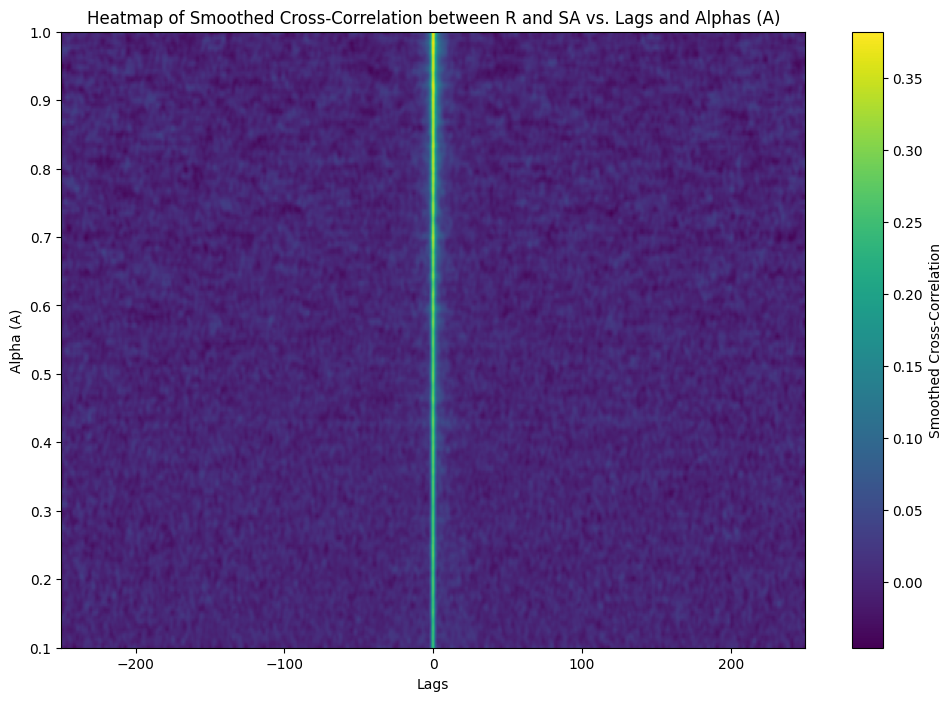

In [1]:
import numpy as np
import pandas as pd
from OOP_SyntheticData import Simulation
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

def SAR_Generator(states, actions, rewards, expert_series):
    start, finish = expert_series[0]  # Taking the first segment
    new_states  = states[start:finish +1]
    new_actions = actions[start:finish +1]
    new_rewards = rewards[start:finish +1]
    return new_states, new_actions, new_rewards

def cross_correlation_manual(x, y, lag_var, mx_lag):
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    c_lag = []

    for lag in range(-mx_lag, mx_lag + 1):
        if lag_var == 'x':
            if lag >= 0:
                segment_x = x[lag:]
                segment_y = y[:len(x) - lag]
            else:
                segment_x = x[:len(x) + lag]
                segment_y = y[-lag:]
        else:
            if lag >= 0:
                segment_x = x[:len(x) - lag]
                segment_y = y[lag:]
            else:
                segment_x = x[-lag:]
                segment_y = y[:len(y) + lag]

        
        min_len = len(segment_x)  # This is len(x) - abs(lag)
        segment_y = segment_y[:min_len]

        std_x = np.std(segment_x)
        std_y = np.std(segment_y)
        c = np.sum((segment_x - mean_x) * (segment_y - mean_y))
        normalization_factor = float(std_x) * float(std_y) * min_len
        
        if normalization_factor != 0:
            c_lag.append(c / normalization_factor)
        else:
            c_lag.append(0)
    
    return c_lag

def AR_mapping(states, actions, rewards, expert_series):
    States, Actions, Rewards = SAR_Generator(states, actions, rewards, expert_series)
    Y = []
    for i in range(len(Actions)):
        if Actions[i] == 'L' and Rewards[i] == 1:
            Y_i = 2
        elif Actions[i] == 'L' and Rewards[i] == 0:
            Y_i = 1
        elif Actions[i] == 'R' and Rewards[i] == 0:
            Y_i = -1
        elif Actions[i] == 'R' and Rewards[i] == 1:
            Y_i = -2
        elif Actions[i] == 'N':
            Y_i = 0
        Y.append(Y_i)
    return Y

def S_mapping(states, actions, rewards, expert_series):
    States, Actions, Rewards = SAR_Generator(states, actions, rewards, expert_series)
    X = []
    for i in range(len(States)):
        if States[i] == '6kHz':
            X_i = 1
        elif States[i] == '10kHz':
            X_i = -1
        X.append(X_i)
    return X

def SA_mapping(states, actions, rewards, expert_series):
    States, Actions, Rewards = SAR_Generator(states, actions, rewards, expert_series)
    X = []
    for i in range(len(States)):
        if (States[i] == '6kHz' and Actions[i] == 'L') or (States[i] == '10kHz' and Actions[i] == 'R'):
            X_i = 1
        elif (States[i] == '6kHz' and Actions[i] == 'R') or (States[i] == '10kHz' and Actions[i] == 'L'):
            X_i = -1
        else:
            X_i = 0
        X.append(X_i)
    return X

def A_mapping(states, actions, rewards, expert_series):
    States, Actions, Rewards = SAR_Generator(states, actions, rewards, expert_series)
    Y = []
    for i in range(len(Actions)):
        if Actions[i] == 'L':
            Y_i = 1
        elif Actions[i] == 'R':
            Y_i = -1
        else:
            Y_i = 0
        Y.append(Y_i)
    return Y

def R_mapping(states, actions, rewards, expert_series):
    States, Actions, Rewards = SAR_Generator(states, actions, rewards, expert_series)
    X = []
    for i in range(len(Rewards)):
        if Rewards[i] == 1:
            X_i = 1
        else:
            X_i = 0
        X.append(X_i)
    return X

def avg_correlate(states, actions, rewards, expert_series, expert_length):
    max_lag = int(0.2 * expert_length)
    R_seq = R_mapping(states, actions, rewards, expert_series)
    SA_seq = SA_mapping(states, actions, rewards, expert_series)
    
    cross_corr = cross_correlation_manual(R_seq, SA_seq, SA_seq, max_lag)
    lags = list(range(-max_lag, max_lag + 1))
    return cross_corr, lags

def gaussian_smoothing_3d(data, sigma):
    # Applying Gaussian filter to each 2D slice separately
    return gaussian_filter(data, sigma=sigma)

def compute_heatmap_data(T, A_vals, ps, B, sigma, expert_length):
    heatmap_data = []
    lags = None
    
    for A in A_vals:
        sim = Simulation(T, ps, expert_length)
        states, actions, rewards, _, _, expert_series = sim.Generate_SAR(A, B)
        y_mouse_rev, x_mouse_rev = avg_correlate(states, actions, rewards, expert_series, expert_length)

        y_mouse_rev_smoothed = np.array(y_mouse_rev)  # Converting to numpy array for filtering
        
        if lags is None:
            lags = x_mouse_rev  # Assuming lags are the same for all B values
        
        heatmap_data.append(y_mouse_rev_smoothed)
    
    # Converting heatmap_data to a numpy array with dimensions (B_vals, lags)
    heatmap_data = np.array(heatmap_data)

    # Applying 3D Gaussian filter
    smoothed_heatmap_data = gaussian_smoothing_3d(heatmap_data, sigma)

    return smoothed_heatmap_data, lags

# Parameters
B = float(input('What beta (B) would you like? '))
p = float(input('What p value would you like between 0.5 and 1? '))
sigma = float(input('What sigma value for Gaussian smoothing would you like? '))
T = int(input('What number of trials would you like? '))
N = int(input("What number of elements would you like?"))
A_vals = np.linspace(0.1, 1, N)  # Varying beta along the y-axis

# Computing heatmap data
smoothed_heatmap_data, lags = compute_heatmap_data(T, A_vals, p, B, sigma, expert_length=N/0.2)
print(f"Sigma = {sigma}", f"B = {B}", f"T = {T}", f"p = {p}")
print(f'Length of expert phase = {N}')
# Creating heatmap
plt.figure(figsize=(12, 8))
plt.imshow(smoothed_heatmap_data, aspect='auto', cmap='viridis', extent=[lags[0], lags[-1], A_vals[0], A_vals[-1]], origin='lower')
plt.colorbar(label='Smoothed Cross-Correlation')
plt.xlabel('Lags')
plt.ylabel('Alpha (A)')
plt.title('Heatmap of Smoothed Cross-Correlation between R and SA vs. Lags and Alphas (A)')
plt.show()



Sigma = 1.0 A = 0.9 T = 7000 p = 0.9
Length of expert phase = 250


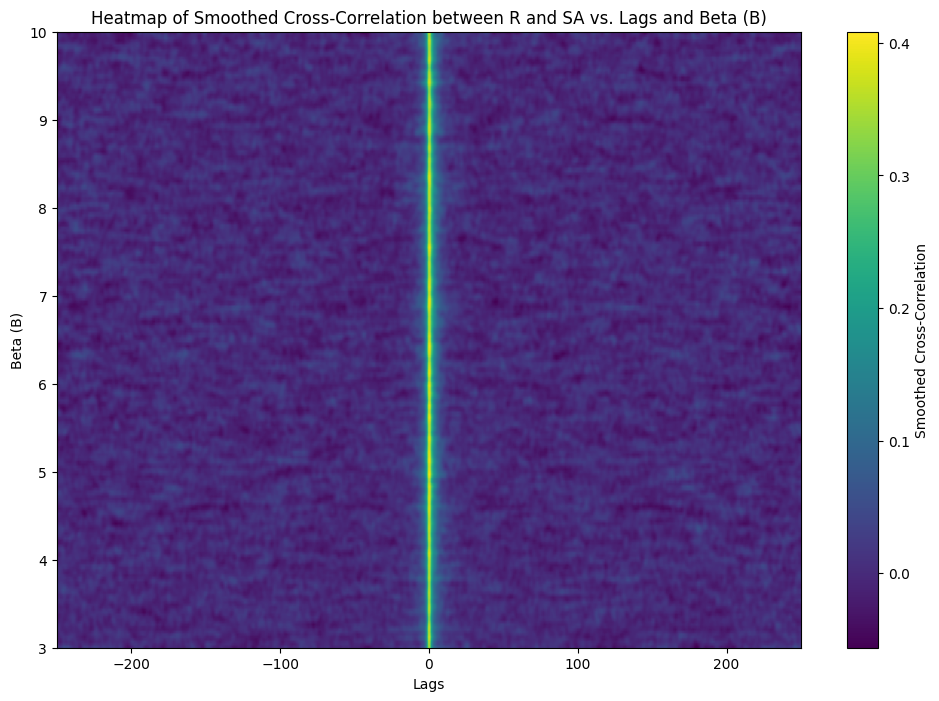

In [1]:
import numpy as np
import pandas as pd
from OOP_SyntheticData import Simulation
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

def SAR_Generator(states, actions, rewards, expert_series):
    start, finish = expert_series[0]  # Taking the first segment
    new_states  = states[start:finish +1]
    new_actions = actions[start:finish +1]
    new_rewards = rewards[start:finish +1]
    return new_states, new_actions, new_rewards

def cross_correlation_manual(x, y, lag_var, mx_lag):
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    c_lag = []

    for lag in range(-mx_lag, mx_lag + 1):
        if lag_var == 'x':
            if lag >= 0:
                segment_x = x[lag:]
                segment_y = y[:len(x) - lag]
            else:
                segment_x = x[:len(x) + lag]
                segment_y = y[-lag:]
        else:
            if lag >= 0:
                segment_x = x[:len(x) - lag]
                segment_y = y[lag:]
            else:
                segment_x = x[-lag:]
                segment_y = y[:len(y) + lag]

        
        min_len = len(segment_x)  # This is len(x) - abs(lag)
        segment_y = segment_y[:min_len]

        std_x = np.std(segment_x)
        std_y = np.std(segment_y)
        c = np.sum((segment_x - mean_x) * (segment_y - mean_y))
        normalization_factor = float(std_x) * float(std_y) * min_len
        
        if normalization_factor != 0:
            c_lag.append(c / normalization_factor)
        else:
            c_lag.append(0)
    
    return c_lag

def AR_mapping(states, actions, rewards, expert_series):
    States, Actions, Rewards = SAR_Generator(states, actions, rewards, expert_series)
    Y = []
    for i in range(len(Actions)):
        if Actions[i] == 'L' and Rewards[i] == 1:
            Y_i = 2
        elif Actions[i] == 'L' and Rewards[i] == 0:
            Y_i = 1
        elif Actions[i] == 'R' and Rewards[i] == 0:
            Y_i = -1
        elif Actions[i] == 'R' and Rewards[i] == 1:
            Y_i = -2
        elif Actions[i] == 'N':
            Y_i = 0
        Y.append(Y_i)
    return Y

def S_mapping(states, actions, rewards, expert_series):
    States, Actions, Rewards = SAR_Generator(states, actions, rewards, expert_series)
    X = []
    for i in range(len(States)):
        if States[i] == '6kHz':
            X_i = 1
        elif States[i] == '10kHz':
            X_i = -1
        X.append(X_i)
    return X

def SA_mapping(states, actions, rewards, expert_series):
    States, Actions, Rewards = SAR_Generator(states, actions, rewards, expert_series)
    X = []
    for i in range(len(States)):
        if (States[i] == '6kHz' and Actions[i] == 'L') or (States[i] == '10kHz' and Actions[i] == 'R'):
            X_i = 1
        elif (States[i] == '6kHz' and Actions[i] == 'R') or (States[i] == '10kHz' and Actions[i] == 'L'):
            X_i = -1
        else:
            X_i = 0
        X.append(X_i)
    return X

def A_mapping(states, actions, rewards, expert_series):
    States, Actions, Rewards = SAR_Generator(states, actions, rewards, expert_series)
    Y = []
    for i in range(len(Actions)):
        if Actions[i] == 'L':
            Y_i = 1
        elif Actions[i] == 'R':
            Y_i = -1
        else:
            Y_i = 0
        Y.append(Y_i)
    return Y

def R_mapping(states, actions, rewards, expert_series):
    States, Actions, Rewards = SAR_Generator(states, actions, rewards, expert_series)
    X = []
    for i in range(len(Rewards)):
        if Rewards[i] == 1:
            X_i = 1
        else:
            X_i = 0
        X.append(X_i)
    return X

def avg_correlate(states, actions, rewards, expert_series, expert_length):
    max_lag = int(0.2 * expert_length)
    R_seq = R_mapping(states, actions, rewards, expert_series)
    SA_seq = SA_mapping(states, actions, rewards, expert_series)
    
    cross_corr = cross_correlation_manual(R_seq, SA_seq, SA_seq, max_lag)
    lags = list(range(-max_lag, max_lag + 1))
    return cross_corr, lags

def gaussian_smoothing_3d(data, sigma):
    # Applying Gaussian filter to each 2D slice separately
    return gaussian_filter(data, sigma=sigma)

def compute_heatmap_data(T, A, ps, B_vals, sigma, expert_length):
    heatmap_data = []
    lags = None
    
    for B in B_vals:
        sim = Simulation(T, ps, expert_length)
        states, actions, rewards, _, _, expert_series = sim.Generate_SAR(A, B)
        y_mouse_rev, x_mouse_rev = avg_correlate(states, actions, rewards, expert_series, expert_length)

        y_mouse_rev_smoothed = np.array(y_mouse_rev)  # Converting to numpy array for filtering
        
        if lags is None:
            lags = x_mouse_rev  # Assuming lags are the same for all B values
        
        heatmap_data.append(y_mouse_rev_smoothed)
    
    # Converting heatmap_data to a numpy array with dimensions (B_vals, lags)
    heatmap_data = np.array(heatmap_data)

    # Applying 3D Gaussian filter
    smoothed_heatmap_data = gaussian_smoothing_3d(heatmap_data, sigma)

    return smoothed_heatmap_data, lags

# Parameters
A = float(input('What learning rate (A) would you like? '))
p = float(input('What p value would you like between 0.5 and 1? '))
sigma = float(input('What sigma value for Gaussian smoothing would you like? '))
T = int(input('What number of trials would you like? '))
N = int(input("What number of elements would you like?"))
B_vals = np.linspace(3, 10, N)  # Varying beta along the y-axis

# Computing heatmap data
smoothed_heatmap_data, lags = compute_heatmap_data(T, A, p, B_vals, sigma, expert_length=N/0.2)
print(f"Sigma = {sigma}", f"A = {A}", f"T = {T}", f"p = {p}")
print(f'Length of expert phase = {N}')
# Creating heatmap
plt.figure(figsize=(12, 8))
plt.imshow(smoothed_heatmap_data, aspect='auto', cmap='viridis', extent=[lags[0], lags[-1], B_vals[0], B_vals[-1]], origin='lower')
plt.colorbar(label='Smoothed Cross-Correlation')
plt.xlabel('Lags')
plt.ylabel('Beta (B)')
plt.title('Heatmap of Smoothed Cross-Correlation between R and SA vs. Lags and Beta (B)')
plt.show()
